In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import sys,os
from tqdm import tqdm_notebook as tqdm

c = 'Kaggle-IEEE-CIS-Fraud-Detection-2019'
root = 'F:/home/daishu/competition/%s/'%c
id_name = 'TransactionID'
label_name = 'isFraud'

In [2]:
train_df1 = pd.read_csv('%s/data/train_identity.csv'%root)
train_df2 = pd.read_csv('%s/data/train_transaction.csv'%root)

test_df1 = pd.read_csv('%s/data/test_identity.csv'%root)
test_df2 = pd.read_csv('%s/data/test_transaction.csv'%root)

In [3]:
train_df1.shape,train_df2.shape

((144233, 41), (590540, 394))

In [4]:
train_df = train_df2.merge(train_df1,how='left',on=id_name)
test_df = test_df2.merge(test_df1,how='left',on=id_name)

In [5]:
del train_df1,train_df2,test_df1,test_df2
train_df.shape

(590540, 434)

In [6]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def Information_entropy(x):
    x = pd.Series(x)
    pct = x.groupby(by=x).count() / len(x)
    return np.sum(-pct*np.log2(pct))

def Mutual_information(x,y):
    df = pd.DataFrame({'x':x,'y':y})
    entropy = Information_entropy(y)
    conditiona_entropy = df.groupby(['x']).agg({'y':Information_entropy})
    pct = df.groupby(['x']).count() / len(x)
    return entropy - np.sum(pct.values*conditiona_entropy.values)

def Data_review(trainDf,testDf,idName,labelName):
    info = []
    info.append([idName,'object',trainDf.shape[0],testDf.shape[0],0,'0.00%',np.nan,np.nan,np.nan,np.nan,np.nan])
    info.append([labelName,trainDf[labelName].dtype,trainDf.shape[0],testDf.shape[0],np.nan,np.nan,trainDf[labelName].mean(),np.nan,np.nan,np.nan,np.nan])
    for col in tqdm(trainDf.columns):
        if col in [idName,labelName]:
            continue
        data_type = trainDf[col].dtype
        train_nunique = trainDf[col].nunique() + (trainDf[col].isna().sum()>0)
        test_nunique = testDf[col].nunique() + (testDf[col].isna().sum()>0)
        train_test_intersection = len(set(trainDf[col].unique())&(set(testDf[col].unique())))
        intersectiom_pct = '%.2f%%'%(train_test_intersection/train_nunique*100)
        if data_type == 'object':
            train_mode_or_mean = trainDf[col].mode().values[0]
            test_mode_or_mean = testDf[col].mode().values[0]
            mi_or_corr = Mutual_information(trainDf[col],trainDf[labelName])
        else:
            train_mode_or_mean = trainDf[col].mean()
            test_mode_or_mean = testDf[col].mean()
            mi_or_corr = trainDf[col].corr(trainDf[labelName])
        train_nan_num = trainDf[col].isnull().sum()
        test_nan_num = testDf[col].isnull().sum()
        info.append([col,data_type,train_nunique,test_nunique,train_test_intersection,intersectiom_pct,train_mode_or_mean,test_mode_or_mean,train_nan_num,test_nan_num,mi_or_corr])
    info_df = pd.DataFrame(info,columns=['column','dataType','trainNunique','testNunique','trainTestIntersection','intersectionPct','trainModeOrMean','testModeOrMean','trainNanNum','testNanNum','miOrCorr'])
    return info_df

In [9]:
info_df = Data_review(train_df,test_df,id_name,label_name)

In [10]:
info_df

,column,dataType,trainNunique,testNunique,trainTestIntersection,intersectionPct,trainModeOrMean,testModeOrMean,trainNanNum,testNanNum,miOrCorr
0,TransactionID,object,590540,506691,0.0,0.00%,NaN,NaN,NaN,NaN,NaN
1,isFraud,int64,590540,506691,NaN,NaN,0.03499,NaN,NaN,NaN,NaN
2,TransactionDT,int64,573349,494686,0.0,0.00%,7.37231e+06,2.69299e+07,0.0,0.0,0.013103
3,TransactionAmt,float64,20902,14119,5215.0,24.95%,135.027,134.726,0.0,0.0,0.011320
4,ProductCD,object,5,5,5.0,100.00%,W,W,0.0,0.0,0.014839
5,card1,int64,13553,13244,9706.0,71.62%,9898.73,9957.22,0.0,0.0,-0.013640
6,card2,float64,501,498,496.0,99.00%,362.555,363.735,8933.0,8654.0,0.003388
7,card3,float64,115,116,96.0,83.48%,153.195,153.543,1565.0,3002.0,0.154151
8,card4,object,5,5,5.0,100.00%,visa,visa,1577.0,3086.0,0.000809
9,card5,float64,120,103,83.0,69.17%,199.279,200.163,4259.0,4547.0,-0.033580


In [18]:
sorted(list(train_df['TransactionAmt'].unique()),reverse=True)

[31937.391,
 6450.97,
 6085.23,
 5543.23,
 5420.0,
 5366.82,
 5279.95,
 5278.95,
 5277.95,
 5191.0,
 5094.95,
 5047.47,
 5001.82,
 4989.97,
 4976.31,
 4879.95,
 4843.75,
 4836.33,
 4829.95,
 4817.58,
 4817.47,
 4652.92,
 4633.34,
 4631.0,
 4606.58,
 4592.02,
 4577.7,
 4548.35,
 4547.47,
 4545.36,
 4517.71,
 4515.95,
 4463.95,
 4452.07,
 4451.95,
 4437.95,
 4425.97,
 4409.87,
 4394.95,
 4391.0,
 4322.17,
 4309.19,
 4301.95,
 4299.36,
 4298.41,
 4222.95,
 4220.39,
 4199.55,
 4194.95,
 4191.0,
 4146.66,
 4114.62,
 4113.77,
 4077.08,
 4072.95,
 4072.7,
 4062.97,
 4041.08,
 4039.96,
 4026.97,
 4022.95,
 4011.95,
 4007.95,
 4006.79,
 3996.53,
 3991.47,
 3986.8,
 3984.95,
 3983.51,
 3975.79,
 3967.81,
 3945.95,
 3941.08,
 3929.51,
 3891.0,
 3866.7,
 3848.32,
 3839.97,
 3839.95,
 3829.81,
 3826.3,
 3822.95,
 3786.27,
 3704.01,
 3694.95,
 3684.11,
 3644.95,
 3619.95,
 3618.31,
 3594.95,
 3584.95,
 3582.95,
 3565.95,
 3555.95,
 3555.75,
 3546.95,
 3545.06,
 3535.62,
 3511.95,
 3501.28,
 3500.0,


In [19]:
sorted(test_df['TransactionAmt'].unique(),reverse=True)

[10270.0,
 9801.5,
 9601.5,
 9333.0,
 9154.46,
 8814.5,
 7926.42,
 7777.49,
 6759.0,
 6609.95,
 6532.95,
 6279.95,
 6222.0,
 6197.36,
 6079.95,
 5979.95,
 5976.8,
 5858.16,
 5605.46,
 5487.36,
 5279.95,
 5191.0,
 5139.97,
 5094.95,
 5041.0,
 5011.95,
 5007.95,
 4979.95,
 4962.07,
 4922.95,
 4892.81,
 4884.8,
 4838.87,
 4812.95,
 4790.95,
 4785.83,
 4751.95,
 4723.19,
 4692.25,
 4691.0,
 4688.02,
 4687.89,
 4663.67,
 4645.5,
 4631.19,
 4604.95,
 4595.8,
 4573.79,
 4550.5,
 4525.97,
 4499.95,
 4492.72,
 4481.62,
 4451.95,
 4442.26,
 4424.07,
 4415.55,
 4369.66,
 4366.95,
 4340.55,
 4327.02,
 4306.95,
 4305.13,
 4292.83,
 4222.95,
 4212.42,
 4191.0,
 4182.95,
 4164.69,
 4164.64,
 4148.55,
 4139.85,
 4138.92,
 4127.9,
 4122.95,
 4111.47,
 4095.5,
 4094.95,
 4093.78,
 4092.52,
 4075.24,
 4062.43,
 4046.19,
 4046.18,
 4041.0,
 4031.47,
 4007.95,
 4004.3,
 3986.06,
 3980.62,
 3976.71,
 3975.67,
 3972.11,
 3957.95,
 3948.46,
 3941.0,
 3932.35,
 3922.95,
 3904.88,
 3902.6,
 3891.54,
 3865.38,
 

In [159]:
id_cols = ['id_12','id_15','id_16','id_27','id_28','id_29']
train_df.loc[((train_df[id_cols]=='NotFound').sum(axis=1)>0),'isFraud'].mean()

0.08172634717244441

In [63]:
cols = ['D1','V281','V282','V283','V288','V289','V296','V300','V301','V313','V314','V315']
for col in cols:
    train_df[col] = train_df[col].fillna(-999)
train_df['f'] = train_df[cols].sum(axis=1)

In [78]:
train_df[['V306','TransactionAmt',label_name]].corr()

,V306,TransactionAmt,isFraud
V306,1.000000,0.035334,-0.00187
TransactionAmt,0.035334,1.000000,0.01132
isFraud,-0.001870,0.011320,1.00000


In [70]:
f = 'V307'
train_df[[f,label_name]].groupby([f]).agg(['count','mean']).sort_values(by=[('isFraud','count')],ascending=False)

isFraud          
                count      mean
V307                           
0.000000       316650  0.032023
107.949997       6360  0.007862
57.950001        5672  0.004231
59.000000        5418  0.014766
117.000000       5247  0.023442
100.000000       3307  0.037194
49.000000        2687  0.026796
50.000000        2291  0.031864
226.000000       2280  0.032456
47.950001        2248  0.003559
200.000000       2005  0.052868
35.950001        1937  0.004130
39.000000        1771  0.018069
30.950001        1704  0.002347
209.949997       1675  0.011343
150.000000       1586  0.073770
215.899994       1581  0.017710
29.000000        1549  0.014848
25.950001        1541  0.002596
115.900002       1538  0.005202
171.000000       1445  0.032526
159.949997       1314  0.006849
67.949997        1291  0.003098
234.000000       1261  0.038858
34.000000        1239  0.014528
77.000000        1232  0.034903
300.000000       1183  0.089603
118.000000       1183  0.013525
335.000000       1110  0.038739
165.899994       1013  0.007897
...               ...       ...
96.400597           1  0.000000
547.989990          1  0.000000
547.900024          1  0.000000
96.406998           1  0.000000
547.799988          1  0.000000
96.419998           1  0.000000
549.619995          1  0.000000
96.309502           1  0.000000
549.789978          1  0.000000
96.295700           1  0.000000
550.979980          1  1.000000
550.969971          1  0.000000
550.960022          1  0.000000
96.078400           1  0.000000
96.093300           1  1.000000
550.880005          1  0.000000
550.869995          1  0.000000
550.849976          1  0.000000
96.154701           1  0.000000
550.799988          1  0.000000
550.585205          1  1.000000
96.189201           1  0.000000
550.002197          1  1.000000
96.202003           1  0.000000
96.246902           1  0.000000
549.900024          1  0.000000
96.277702           1  0.000000
549.827271          1  0.000000
549.820007          1  0.000000
145765.000000       1  0.000000

[37368 rows x 2 columns]

In [71]:
f = 'TransactionAmt'
train_df[[f,label_name]].groupby([f]).agg(['count','mean']).sort_values(by=[('isFraud','count')],ascending=False)

isFraud          
                 count      mean
TransactionAmt                  
59.000           30582  0.021124
117.000          28933  0.024851
107.950          23954  0.009226
57.950           23600  0.003814
100.000          20362  0.025685
50.000           17009  0.020754
49.000           15990  0.029331
226.000          11704  0.033322
39.000           11095  0.021812
29.000           10683  0.018815
47.950            9655  0.003521
35.950            8909  0.002918
150.000           8356  0.067137
171.000           7682  0.035407
34.000            7652  0.018296
30.950            7649  0.003791
25.000            7500  0.017467
77.000            7389  0.035999
25.950            7294  0.002879
200.000           6590  0.064188
209.950           6115  0.008504
335.000           5534  0.042284
67.950            5403  0.003331
75.000            5107  0.025064
159.950           4716  0.011450
97.000            4678  0.045532
92.000            4280  0.033879
58.950            3798  0.005003
30.000            3571  0.026603
108.950           3564  0.007576
...                ...       ...
393.470              1  0.000000
393.500              1  0.000000
393.670              1  0.000000
393.700              1  0.000000
393.760              1  0.000000
71.884               1  0.000000
393.810              1  0.000000
392.460              1  0.000000
392.450              1  0.000000
392.400              1  0.000000
391.920              1  0.000000
391.370              1  0.000000
391.400              1  0.000000
391.600              1  0.000000
391.650              1  0.000000
72.177               1  0.000000
391.780              1  0.000000
391.800              1  0.000000
72.150               1  0.000000
72.146               1  0.000000
392.390              1  0.000000
72.097               1  0.000000
391.990              1  0.000000
392.020              1  0.000000
392.050              1  0.000000
392.160              1  0.000000
392.200              1  0.000000
392.250              1  0.000000
392.320              1  0.000000
0.251                1  0.000000

[20902 rows x 2 columns]

In [ ]:
train_df['DeviceInfo'] = train_df['DeviceInfo'].fillna('-999').apply(lambda x:x.lower())
def Get_device(x):
    os_list = ['sm','ios','mac','linux','android','func']
    for o in os_list:
        if o in x:
            return o
    return x
train_df['f'] = train_df['id_30'].apply(lambda x:Get_os(x))

In [156]:
f = 'DeviceInfo'
train_df[[f,label_name]].groupby([f]).agg(['count','mean']).sort_values(by=[('isFraud','count')],ascending=False)

isFraud          
                                 count      mean
DeviceInfo                                      
Windows                          47722  0.065400
iOS Device                       19782  0.062683
MacOS                            12573  0.022111
Trident/7.0                       7440  0.012903
rv:11.0                           1901  0.039979
rv:57.0                            962  0.107069
SM-J700M Build/MMB29K              549  0.109290
SM-G610M Build/MMB29K              461  0.080260
SM-G531H Build/LMY48B              410  0.080488
rv:59.0                            362  0.121547
SM-G935F Build/NRD90M              334  0.092814
SM-G955U Build/NRD90M              328  0.100610
SM-G532M Build/MMB29T              316  0.037975
ALE-L23 Build/HuaweiALE-L23        312  0.092949
SM-G950U Build/NRD90M              290  0.055172
SM-G930V Build/NRD90M              274  0.000000
rv:58.0                            269  0.182156
rv:52.0                            256  0.046875
SAMSUNG                            235  0.021277
SM-G950F Build/NRD90M              225  0.151111
Moto G (4) Build/NPJ25.93-14.7     219  0.182648
SM-N950U Build/NMF26X              209  0.062201
SM-A300H Build/LRX22G              203  0.832512
hi6210sft Build/MRA58K             190  0.947368
SM-J730GM Build/NRD90M             184  0.146739
SM-G570M Build/MMB29K              182  0.016484
rv:48.0                            178  0.011236
CAM-L03 Build/HUAWEICAM-L03        172  0.127907
SM-J320M Build/LMY47V              171  0.333333
LG-M700 Build/NMF26X               169  0.171598
...                                ...       ...
SAMSUNG-SM-G890A                     1  0.000000
SAMSUNG-SM-G900A                     1  0.000000
SAMSUNG-SM-G925A                     1  0.000000
SAMSUNG-SM-G930AZ                    1  0.000000
SAMSUNG-SM-J327AZ                    1  0.000000
SAMSUNG-SM-N920A                     1  0.000000
SAMSUNG-SM-T377A                     1  0.000000
SAMSUNG-SM-T537A                     1  0.000000
S6000                                1  0.000000
S471                                 1  0.000000
Robin                                1  0.000000
Redmi Note 5A Build/N2G47H           1  0.000000
Northwell                            1  0.000000
O1                                   1  0.000000
ORION                                1  0.000000
P00A                                 1  0.000000
P01M                                 1  0.000000
P027                                 1  0.000000
PLAYTAB                              1  0.000000
PLE-701L                             1  0.000000
PLK-L01 Build/HONORPLK-L01           1  0.000000
PMID7102DC                           1  0.000000
PRA507                               1  0.000000
QMV7A                                1  0.000000
QTASUN1                              1  0.000000
QwestIE8                             1  0.000000
R8106                                1  0.000000
0PJA2                                1  0.000000
RCT6K03W13                           1  0.000000
xs-Z47b7VqTMxs                       1  0.000000

[1786 rows x 2 columns]

In [91]:
Mutual_information(train_df.loc[train_df['f']!='-999',label_name],train_df.loc[train_df['f']!='-999','f'])

0.00642022551406396

In [ ]:
info_df

In [11]:
info_df.to_csv('%s/data/info.csv'%root,index=False)

In [116]:
train_df[['f',label_name]].sort_values(by=['f'],ascending=False)

,f,isFraud
526013,4545.360000,0
489105,3454.950000,0
128466,3381.950000,0
429425,3263.490000,0
296902,3221.000000,1
124785,2741.770000,0
91420,2629.970000,0
154137,2594.950000,0
151608,2594.940000,0
526080,2463.930000,0


In [122]:
train_df.loc[tmp['card']=='2102_555_143_visa_102_credit']

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,f
296902,3283902,1,7333909,3221.0,W,2102,555.0,143.0,visa,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3221.0


In [49]:
def Get_groupby_f(df,f):
    return df.groupby([f])[label_name].agg(['count','mean']).sort_values(by=['count'],ascending=False)

In [50]:
Get_groupby_f(tmp,'card1')

,count,mean
card1,,
7919,14932,0.007501
9500,14162,0.037283
15885,10361,0.042853
17188,10344,0.026875
15066,7945,0.039396
12695,7091,0.028346
12544,6773,0.021556
6019,6771,0.043420
2803,6141,0.011887


In [41]:
tmp.loc[tmp['card1']==9917,list(tmp.columns)[:11]]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
401020,3388020,1,10108000,78.667,C,9917,142.0,185.0,visa,138.0,debit
401047,3388047,1,10108394,78.667,C,9917,142.0,185.0,visa,138.0,debit
401144,3388144,1,10109872,81.446,C,9917,142.0,185.0,visa,138.0,debit
401152,3388152,1,10109982,81.446,C,9917,142.0,185.0,visa,138.0,debit
401164,3388164,1,10110148,40.723,C,9917,142.0,185.0,visa,138.0,debit
401166,3388166,1,10110185,40.723,C,9917,142.0,185.0,visa,138.0,debit
401204,3388204,1,10110631,40.723,C,9917,142.0,185.0,visa,138.0,debit
401206,3388206,1,10110664,78.667,C,9917,142.0,185.0,visa,138.0,debit
401251,3388251,1,10111633,40.723,C,9917,142.0,185.0,visa,138.0,debit
401258,3388258,1,10111686,40.723,C,9917,142.0,185.0,visa,138.0,debit


In [39]:
tmp.loc[tmp['card1']==9917,list(tmp.columns)[:11]].groupby(['TransactionAmt'])[label_name].agg(['count','mean'])

,count,mean
TransactionAmt,,
9.667,1,0.0
12.326,1,0.0
28.156,1,0.0
28.277,4,0.5
29.183,10,1.0
30.210,1,1.0
32.264,1,1.0
36.856,4,1.0
40.723,9,1.0


In [56]:
tmp.loc[(tmp['card1']==9917)&(tmp['TransactionAmt']>=28.27)&(tmp['TransactionAmt']<=28.28),list(tmp.columns)[:17]]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
401393,3388393,1,10114050,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com
401506,3388506,0,10116475,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
401708,3388708,1,10122531,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com
401795,3388795,0,10125587,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com


In [10]:
train_df['V258'].unique()

array([nan,  1.,  2.,  3., 60.,  4., 61., 62., 63.,  8.,  5.,  6., 64.,
        9., 65., 66.,  7., 35., 36., 46., 44., 45., 47., 10., 11., 48.,
       12., 13., 49., 14., 50., 51., 52., 53., 54., 55., 56., 15., 57.,
       58., 59., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 37., 38., 39., 40., 41.,
       42., 43.,  0.])

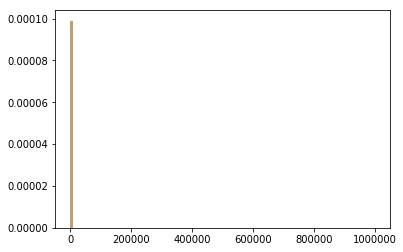

In [47]:
c = 'id_02'
min_value = min(train_df[c].dropna().min(),test_df[c].dropna().min())
max_value = max(train_df[c].dropna().max(),test_df[c].dropna().max())
bins = np.linspace(min_value,max_value,100)
plt.hist(train_df['V201'].dropna().values,bins=bins,alpha=0.5,normed=True)
plt.hist(test_df['V201'].dropna().values,bins=bins,alpha=0.5,normed=True)
plt.show()

In [20]:
tmp.loc[(tmp['f']>3350)&(tmp['f']<3400)]

,f,isFraud
364,3351,0.035
365,3352,0.041
366,3353,0.045
367,3354,0.036
368,3355,0.065
369,3356,0.037
370,3357,0.057
371,3358,0.035
372,3359,0.057
373,3360,0.045


In [16]:
test_df['TransactionID'].max()-test_df['TransactionID'].min()

506690

In [71]:
info_df.to_csv('%s/data/info.csv'%root,index=False)

In [11]:
train_df['id_03'].nunique()

24

In [18]:
def Get_card_id(df):
    card_info = ['card%s'%(i+1) for i in range(6)]
    card_info.extend(['P_emaildomain','R_emaildomain'])
    tmp = df[card_info]
    for col in tmp.columns:
        tmp[col] = tmp[col].astype(str).apply(lambda x:x.replace('.0',''))
    tmp['card'] = tmp[card_info].apply(lambda x:'_'.join(x),axis=1)
    return tmp

In [45]:
tmp1 = Get_card_id(test_df)

In [19]:
tmp = Get_card_id(train_df)
tmp

,card1,card2,card3,card4,card5,card6,P_emaildomain,R_emaildomain,card
0,13926,nan,150,discover,142,credit,nan,nan,13926_nan_150_discover_142_credit_nan_nan
1,2755,404,150,mastercard,102,credit,gmail.com,nan,2755_404_150_mastercard_102_credit_gmail.com_nan
2,4663,490,150,visa,166,debit,outlook.com,nan,4663_490_150_visa_166_debit_outlook.com_nan
3,18132,567,150,mastercard,117,debit,yahoo.com,nan,18132_567_150_mastercard_117_debit_yahoo.com_nan
4,4497,514,150,mastercard,102,credit,gmail.com,nan,4497_514_150_mastercard_102_credit_gmail.com_nan
5,5937,555,150,visa,226,debit,gmail.com,nan,5937_555_150_visa_226_debit_gmail.com_nan
6,12308,360,150,visa,166,debit,yahoo.com,nan,12308_360_150_visa_166_debit_yahoo.com_nan
7,12695,490,150,visa,226,debit,mail.com,nan,12695_490_150_visa_226_debit_mail.com_nan
8,2803,100,150,visa,226,debit,anonymous.com,nan,2803_100_150_visa_226_debit_anonymous.com_nan
9,17399,111,150,mastercard,224,debit,yahoo.com,nan,17399_111_150_mastercard_224_debit_yahoo.com_nan


In [48]:
tmp['card'].nunique()

61858

In [20]:
tmp[label_name] = train_df[label_name]

In [21]:
df = tmp.groupby(['card']).agg({label_name:['count','mean']}).sort_values(by=[(label_name,'mean')],ascending=False)
df.loc[(df[('isFraud','count')]>100)]

isFraud          
                                                     count      mean
card                                                                
15063_nan_150_visa_226_credit_anonymous.com_ano...     174  1.000000
2939_111_150_mastercard_102_credit_gmail.com_nan       113  0.663717
2801_296_185_visa_137_credit_gmail.com_gmail.com       106  0.500000
14649_548_150_visa_226_debit_yahoo.com_nan             177  0.463277
10086_500_185_mastercard_224_credit_gmail.com_g...     155  0.406452
10876_104_185_visa_137_credit_gmail.com_gmail.com      303  0.399340
14276_177_185_mastercard_137_credit_gmail.com_g...     334  0.398204
9917_142_185_visa_138_debit_gmail.com_gmail.com        505  0.398020
4504_500_185_mastercard_219_credit_gmail.com_gm...     336  0.392857
1976_545_185_visa_102_credit_gmail.com_gmail.com       282  0.329787
9633_130_185_visa_138_debit_gmail.com_gmail.com        975  0.311795
2256_545_185_visa_226_credit_gmail.com_gmail.com       506  0.296443
5365_177_185_mastercard_224_credit_gmail.com_gm...     149  0.295302
8755_500_185_mastercard_224_credit_gmail.com_gm...     422  0.289100
9026_545_185_visa_137_credit_gmail.com_gmail.com       760  0.286842
10568_204_185_visa_226_credit_gmail.com_gmail.com      436  0.279817
9917_142_185_visa_138_debit_hotmail.com_hotmail...     294  0.275510
16062_500_185_mastercard_137_credit_gmail.com_g...     330  0.260606
5583_103_185_visa_226_credit_gmail.com_gmail.com       137  0.255474
6054_327_150_discover_nan_credit_gmail.com_nan         183  0.245902
12544_321_150_visa_226_debit_comcast.net_nan           144  0.236111
13413_103_185_visa_137_credit_hotmail.com_hotma...     161  0.229814
14276_177_185_mastercard_137_credit_hotmail.com...     385  0.218182
12184_440_185_visa_138_debit_gmail.com_gmail.com       144  0.215278
9633_296_185_visa_138_debit_gmail.com_gmail.com        833  0.210084
1893_514_150_mastercard_224_credit_aol.com_nan         125  0.208000
2616_327_150_discover_223_credit_nan_gmail.com         116  0.206897
16346_324_185_visa_226_credit_gmail.com_gmail.com      109  0.201835
9633_130_185_visa_138_debit_nan_nan                    101  0.188119
11201_103_185_visa_226_debit_gmail.com_gmail.com       521  0.174664
...                                                    ...       ...
14858_558_150_visa_226_debit_gmail.com_nan             581  0.000000
14858_558_150_visa_226_debit_nan_nan                   193  0.000000
14858_558_150_visa_226_debit_yahoo.com_nan             272  0.000000
14842_370_150_visa_166_debit_gmail.com_nan             120  0.000000
15111_310_150_mastercard_224_debit_nan_nan             123  0.000000
15111_310_150_mastercard_224_debit_yahoo.com_nan       113  0.000000
15111_310_150_mastercard_224_debit_gmail.com_nan       168  0.000000
14165_111_150_mastercard_224_debit_gmail.com_nan       139  0.000000
14649_548_150_visa_226_debit_nan_nan                   201  0.000000
14426_111_150_mastercard_224_debit_yahoo.com_nan       181  0.000000
14502_191_150_visa_226_debit_gmail.com_nan             131  0.000000
1450_215_150_visa_166_debit_gmail.com_nan              109  0.000000
14479_387_150_visa_226_credit_nan_nan                  143  0.000000
15813_251_150_visa_226_debit_gmail.com_nan             214  0.000000
15813_251_150_visa_226_debit_yahoo.com_nan             125  0.000000
15885_545_185_visa_138_debit_yahoo.com.mx_yahoo...     192  0.000000
15678_111_150_mastercard_224_debit_gmail.com_nan       163  0.000000
15775_481_150_mastercard_102_credit_nan_yahoo.com     1447  0.000000
15757_322_150_visa_195_debit_gmail.com_nan             140  0.000000
15773_226_150_mastercard_102_credit_gmail.com_nan      113  0.000000
16115_431_150_visa_166_debit_yahoo.com_nan             107  0.000000
16116_568_150_visa_226_debit_gmail.com_nan             104  0.000000
16132_111_150_visa_226_debit_anonymous.com_nan         150  0.000000
16132_111_150_visa_226_debit_aol.com_nan               199  0.000000
15986_360_150_mastercard_229_debit_yahoo.com_nan 

In [26]:
train_df[['V257','V258']].corr()

,V257,V258
V257,1.000000,0.779436
V258,0.779436,1.000000


In [25]:
train_df.loc[(tmp['card']=='9026_545_185_visa_137_credit_gmail.com_gmail.com'),['isFraud','TransactionAmt','addr1','addr2','P_emaildomain','R_emaildomain','V257','V258']]

,isFraud,TransactionAmt,addr1,addr2,P_emaildomain,R_emaildomain,V257,V258
547,0,64.649,NaN,NaN,gmail.com,gmail.com,1.0,1.0
777,0,150.929,NaN,NaN,gmail.com,gmail.com,NaN,NaN
869,1,83.380,NaN,NaN,gmail.com,gmail.com,1.0,1.0
2109,0,31.418,NaN,NaN,gmail.com,gmail.com,NaN,NaN
2473,0,28.760,NaN,NaN,gmail.com,gmail.com,NaN,NaN
5659,0,60.178,NaN,NaN,gmail.com,gmail.com,NaN,NaN
6064,0,16.313,NaN,NaN,gmail.com,gmail.com,NaN,NaN
6412,0,14.138,NaN,NaN,gmail.com,gmail.com,NaN,NaN
9496,0,10.030,NaN,NaN,gmail.com,gmail.com,1.0,1.0
9569,0,18.186,NaN,NaN,gmail.com,gmail.com,NaN,NaN


In [112]:
np.roll(train_df.loc[(tmp['card']=='5812_408_185_mastercard_224_debit'),'TransactionDT'].diff(),-1)

array([1759., 1643.,  163., ...,  693., 2821.,   nan])

In [72]:
test_df.loc[(tmp1['card']=='9500_321_150_visa_226_debit_59_W'),test_df.columns[:15]]

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain
115,3663664,18405989,59.0,W,9500,321.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,gmail.com
149,3663698,18406862,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,NaN,NaN,gmail.com
203,3663752,18409256,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,2.0,NaN,NaN
1358,3664907,18471867,59.0,W,9500,321.0,150.0,visa,226.0,debit,330.0,87.0,11.0,NaN,yahoo.com
1427,3664976,18473350,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,yahoo.com
1874,3665423,18482001,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,gmail.com
1946,3665495,18483619,59.0,W,9500,321.0,150.0,visa,226.0,debit,433.0,87.0,0.0,NaN,NaN
2070,3665619,18486230,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,1.0,NaN,NaN
2365,3665914,18492145,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,60.0,NaN,gmail.com
2430,3665979,18493731,59.0,W,9500,321.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,gmail.com


In [74]:
train_df[['id_%s'%str(i+1).zfill(2) for i in range(38)]].head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


In [161]:
new_train_df = pd.read_csv('%s/data/new_train.csv'%root)

In [162]:
new_train_df.head()

,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,...,isFraud,mNanNum,nanNum,uniqueCrad0,uniqueCrad0_lastTranDist,uniqueCrad0_lastTranTD,uniqueCrad0_nextTranDist,uniqueCrad0_nextTranTD,vNanNum,uniqueCrad0_amtDivCount
0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,3,234,1.0,-817119_-817119_315_87,9999999.0,315_87_-817119_-817119,9999999.0,177,68.500000
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,6,230,37.0,-817119_-817119_325_87,99999999.0,325_87_205_87,14970.0,170,1.208333
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,211,56.0,-817119_-817119_330_87,99999999.0,330_87_184_87,256.0,159,1.552632
3,2.0,0.0,1.0,0.0,25.0,1.0,5.0,0.0,0.0,0.0,...,0,6,227,30.0,-817119_-817119_476_87,99999999.0,476_87_204_87,1102.0,170,0.253807
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,9,137,1.0,-817119_-817119_420_87,9999999.0,420_87_-817119_-817119,9999999.0,94,50.000000


In [163]:
tmp = Get_card_id(new_train_df)

In [164]:
tmp

,card1,card2,card3,card4,card5,card6,card
0,13926,-817119,150,discover,142,credit,13926_-817119_150_discover_142_credit
1,2755,404,150,mastercard,102,credit,2755_404_150_mastercard_102_credit
2,4663,490,150,visa,166,debit,4663_490_150_visa_166_debit
3,18132,567,150,mastercard,117,debit,18132_567_150_mastercard_117_debit
4,4497,514,150,mastercard,102,credit,4497_514_150_mastercard_102_credit
5,5937,555,150,visa,226,debit,5937_555_150_visa_226_debit
6,12308,360,150,visa,166,debit,12308_360_150_visa_166_debit
7,12695,490,150,visa,226,debit,12695_490_150_visa_226_debit
8,2803,100,150,visa,226,debit,2803_100_150_visa_226_debit
9,17399,111,150,mastercard,224,debit,17399_111_150_mastercard_224_debit


In [165]:
unique_cols = [col for col in new_train_df.columns if 'unique' in col]
unique_cols

['uniqueCrad0',
 'uniqueCrad0_lastTranDist',
 'uniqueCrad0_lastTranTD',
 'uniqueCrad0_nextTranDist',
 'uniqueCrad0_nextTranTD',
 'uniqueCrad0_amtDivCount']

In [177]:
new_train_df.loc[tmp['card']=='16659_170_150_visa_226_credit',['isFraud','TransactionDT','TransactionAmt','ProductCD','addr1','addr2']+unique_cols][:40]

,isFraud,TransactionDT,TransactionAmt,ProductCD,addr1,addr2,uniqueCrad0,uniqueCrad0_lastTranDist,uniqueCrad0_lastTranTD,uniqueCrad0_nextTranDist,uniqueCrad0_nextTranTD,uniqueCrad0_amtDivCount
58,0,87532,380.21,W,299,87,12.0,-817119_-817119_299_87,99999999.0,299_87_330_87,637.0,2.993780
100,0,88169,100.00,H,330,87,12.0,299_87_330_87,637.0,330_87_330_87,39.0,0.787402
104,0,88208,100.00,H,330,87,12.0,330_87_330_87,39.0,330_87_264_87,3406.0,0.787402
327,0,91614,125.00,H,264,87,12.0,330_87_264_87,3406.0,264_87_325_87,45017.0,0.984252
1622,0,136631,50.00,H,325,87,12.0,264_87_325_87,45017.0,325_87_184_87,1035.0,0.393701
1688,0,137666,50.00,S,184,87,12.0,325_87_184_87,1035.0,184_87_191_87,2320.0,0.393701
1863,0,139986,100.00,H,191,87,12.0,184_87_191_87,2320.0,191_87_299_87,341.0,0.787402
1889,0,140327,150.00,H,299,87,12.0,191_87_299_87,341.0,299_87_184_87,2245.0,1.181102
2095,0,142572,25.00,H,184,87,12.0,299_87_184_87,2245.0,184_87_441_87,54.0,0.196850
2098,0,142626,50.00,S,441,87,12.0,184_87_441_87,54.0,441_87_325_87,655.0,0.393701


In [167]:
np.roll(new_train_df.loc[tmp['card']=='12308_360_150_visa_166_debit','TransactionDT'].diff().fillna(99999999),-1)

array([7.0605000e+04, 2.3273000e+04, 6.1601000e+04, 2.4988000e+04,
       9.9999999e+07])

In [178]:
len(['AH-maanshan2-WT/AH-maanshan3-WT', 'GD-jieyang4-WT/jieyangwt/jieyangwt2', 'HB-xiangfan6-DX/xiangfandxxiazai', 'JS-zhenjiangxiazai2-DX/zhenjiangdxxiazai5', 'JX-nanchang10-DX/JX-nanchang8-DX', 'NMG-eerduosi2-WT/eerduosiwt', 'TJ-DX/TJ-DX2', 'YN-zhaotong2-DX/zhaotongdx', 'ZJ-jiaxing10-DX/ZJ-jiaxing9-DX/hainingdx/jiaxingdx/jiaxingdx6', 'ZJ-wenzhou10-DX/ZJ-wenzhou11-DX', 'baichengwt/baichengwt2', 'changzhiwt/changzhiwt5', 'handanwt/handanwt4', 'huaiandxxiazai/huaiandxxiazai2', 'jinchengwt/jinchengwt2/jinchengwt3', 'lanzhoudx/lanzhoudx5', 'wenzhoudx5/wenzhoudx8', 'yichangdx/yichangdx3/yichangdx4/yichangdx5', 'zhaoqingdx/zhaoqingdx2', 'JStaizhoudx', 'nantongdx2', 'nantongdx', 'huaiandxxiazai4', 'JS-nantong3-DX', 'JS-nantong4-DX', 'JS-yangzhou5-DX', 'JS-yancheng6-DX', 'SC-deyang3-DX', 'SC-deyang4-DX', 'SC-chengdu8-DX', 'SC-mianyang2-DX', 'SC-chengdu5-DX', 'SC-chengdu6-DX', 'SC-chengdu9-DX', 'SC-mianyang3-DX', 'HN-xinxiang4-WT', 'GS-lanzhou7-DX', 'GS-lanzhou9-DX', 'GS-tianshui2-DX', 'zhanjiangdx3', 'GD-foshan6-DX', 'GD-shantou2-DX', 'GD-zhanjiang5-DX', 'GD-zhuhai11-DX', 'GD-zhanjiang6-DX', 'GD-zhanjiang10-DX', 'HN-changsha3-WT', 'HN-hengyang8-WT', 'HN-zhuzhou4-DX', 'huzhoudx4', 'wenzhoudx6', 'ZJ-wenzhou2-WT', 'ZJ-hangzhou3-WT', 'suihuawt', 'HLJ-mudanjiang3-WT', 'quanzhoudx', 'fuzhoudx2', 'fuzhoudx3', 'fuzhoudx11', 'fuzhoudx9', 'fuzhoudx10', 'FJ-quanzhou7-DX', 'FJ-quanzhou8-DX', 'FJ-fuzhou3-WT', 'xinyudx', 'JX-yichun2-DX', 'liaotongdx', 'NMG-bayannaoer-WT', 'NMG-huhehaote12-DX', 'NMG-bayannaoer3-WT', 'NMG-wuhai-WT', 'NMG-huhehaote10-DX', 'sipingwt', 'tonghuawt', 'langfangwt', 'qinhuangdaowt2', 'HB-huailai-DX', 'HB-shijiazhuang6-DX', 'yunchengwt', 'SX-lvliang4-WT', 'SX-jinzhong-DX', 'HB-yichang6-DX', 'HB-jingmen-WT', 'HB-xiantao2-DX', 'SX-baoji4-DX', 'LN-anshan2-WT', 'GZ-guiyang5-DX'])

87

In [179]:
len(['FJ-quanzhou7-DX/quanzhoudx', 'FJ-quanzhou8-DX/quanzhoudx6', 'GD-jieyang4-WT/jieyangwt/jieyangwt2', 'JS-zhenjiangxiazai2-DX/zhenjiangdxxiazai5', 'JX-nanchang10-DX/JX-nanchang8-DX', 'JX-pingxiang2-DX/pingxiangdx', 'NMG-eerduosi2-WT/eerduosiwt', 'NMG-huhehaote2-DX/NMG-huhehaote6-DX/huhehaote_dx', 'ZJ-jiaxing10-DX/ZJ-jiaxing9-DX/hainingdx/jiaxingdx/jiaxingdx6', 'ZJ-wenzhou10-DX/ZJ-wenzhou11-DX', 'baichengwt/baichengwt2', 'huaiandxxiazai/huaiandxxiazai2', 'jinchengwt/jinchengwt2/jinchengwt3', 'lanzhoudx/lanzhoudx5', 'wenzhoudx5/wenzhoudx8', 'nantongdx2', 'nantongdx', 'JS-nantong3-DX', 'JS-yancheng6-DX', 'HN-xinxiang3-DX', 'HB-xinxiang2-DX', 'GD-foshan6-DX', 'GD-zhanjiang5-DX', 'GD-zhuhai11-DX', 'GD-jiangmen4-DX', 'GD-zhanjiang6-DX', 'GD-zhanjiang10-DX', 'SC-deyang5-DX', 'SC-mianyang2-DX', 'SC-chengdu5-DX', 'SC-mianyang3-DX', 'HN-changsha3-WT', 'HN-hengyang8-WT', 'zhoushanwtxiazai', 'huzhoudx4', 'wenzhoudx6', 'ZJ-wenzhou2-WT', 'ZJ-hangzhou3-WT', 'HLJ-mudanjiang3-WT', 'FJ-fuzhou3-WT', 'xinyudx', 'JX-yichun2-DX', 'NMG-bayannaoer-WT', 'NMG-bayannaoer3-WT', 'NMG-wuhai-WT', 'NMG-huhehaote10-DX', 'tangshanwt', 'langfangwt', 'qinhuangdaowt2', 'HB-huailai-DX', 'HB-shijiazhuang6-DX', 'SX-lvliang4-WT', 'SX-jinzhong-DX', 'yichangdx', 'HB-yichang6-DX', 'HB-jingmen-WT', 'GS-lanzhou9-DX', 'LN-anshan2-WT'])

58

In [180]:
len(['FJ-quanzhou7-DX/quanzhoudx', 'FJ-quanzhou8-DX/quanzhoudx6', 'GD-jieyang4-WT/jieyangwt/jieyangwt2', 'HB-xiangfan6-DX/xiangfandxxiazai', 'JS-zhenjiangxiazai2-DX/zhenjiangdxxiazai5', 'JX-nanchang10-DX/JX-nanchang8-DX', 'JX-pingxiang2-DX/pingxiangdx', 'NMG-eerduosi2-WT/eerduosiwt', 'NMG-huhehaote2-DX/NMG-huhehaote6-DX/huhehaote_dx', 'SC-deyang3-DX/SC-deyang4-DX', 'ZJ-jiaxing10-DX/ZJ-jiaxing9-DX/hainingdx/jiaxingdx/jiaxingdx6', 'ZJ-jinhua6-DX/jinhuadx2', 'ZJ-wenzhou10-DX/ZJ-wenzhou11-DX', 'baichengwt/baichengwt2', 'changzhiwt/changzhiwt5', 'handanwt/handanwt4', 'jinchengwt/jinchengwt2/jinchengwt3', 'lanzhoudx/lanzhoudx5', 'wenzhoudx5/wenzhoudx8', 'HN-luoyang2-DX', 'HN-xinxiang3-DX', 'HB-xinxiang2-DX', 'GD-foshan6-DX', 'GD-jiangmen4-DX', 'GD-zhanjiang10-DX', 'HN-changsha3-WT', 'HN-hengyang8-WT', 'zhoushanwtxiazai', 'huzhoudx4', 'wenzhoudx6', 'ZJ-wenzhou2-WT', 'ZJ-hangzhou3-WT', 'ZJ-wenzhou12-DX', 'suihuawt', 'HLJ-mudanjiang3-WT', 'fuzhoudx2', 'xinyudx', 'JX-yichun2-DX', 'liaotongdx', 'NMG-bayannaoer-WT', 'NMG-huhehaote12-DX', 'NMG-wuhai-WT', 'NMG-huhehaote10-DX', 'sipingwt', 'nantongdx2', 'yanchengdx2', 'nantongdx', 'huaiandxxiazai4', 'JS-nantong3-DX', 'JS-nantong4-DX', 'JS-zhenjiang2-WT', 'JS-yancheng6-DX', 'JS-yangzhou6-DX', 'langfangwt', 'HB-shijiazhuang9-DX', 'HB-shijiazhuang5-DX', 'HB-huailai-DX', 'HB-shijiazhuang7-DX', 'SX-lvliang4-WT', 'SX-jinzhong-DX', 'yichangdx', 'HB-yichang6-DX', 'HB-jingmen-WT', 'SX-baoji4-DX', 'chengdudx3', 'SC-deyang5-DX', 'SC-mianyang2-DX', 'SC-chengdu5-DX', 'SC-chengdu6-DX', 'SC-chengdu7-DX', 'SC-chengdu9-DX', 'GS-lanzhou9-DX', 'GS-tianshui2-DX', 'GS-lanzhou13-DX', 'GZ-guiyang9-DX', 'LN-anshan2-WT'])

76